## Plant Diseases Detection

# 1. Import Libraries

In [ ]:
# Imports & basic settings

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import seaborn as sns
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

In [25]:
# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Paths and parameters
DATASET_DIR = r"D:\Genesys\Plant dieases detection\data"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 5
MODEL_DIR = "saved_model"


# 2. Prepare tf.data datasets from directory

In [26]:
# First create a dataset with 80% train + 20% val (using validation_split)
train_ds = image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

val_ds = image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("Num classes:", num_classes)


Found 15915 files belonging to 19 classes.
Using 12732 files for training.
Found 15915 files belonging to 19 classes.
Using 3183 files for validation.
Classes: ['Apple_Apple_scab', 'Apple_Black_rot', 'Apple_Cedar_apple_rust', 'Apple_healthy', 'Corn_(maize)_Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)_Common_rust_', 'Corn_(maize)_Northern_Leaf_Blight', 'Corn_(maize)_healthy', 'Grape_Black_rot', 'Grape_Esca_(Black_Measles)', 'Grape_Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape_healthy', 'Potato_Early_blight', 'Potato_Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_Target_Spot', 'Tomato_Tomato_mosaic_virus']
Num classes: 19


# 3. Create a test set

In [ ]:
TEST_DIR = "dataset_test"  

if os.path.exists(TEST_DIR):
    test_ds = image_dataset_from_directory(
        TEST_DIR,
        labels="inferred",
        label_mode="int",
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=False
    )
else:
    test_ds = val_ds


# 4. Performance optimizations

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 5. Data augmentation + preprocessing for MobileNetV2

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)

# MobileNetV2 expects inputs preprocessed by tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input = keras.applications.mobilenet_v2.preprocess_input


# 6. Build MobileNetV2 transfer learning model

In [30]:
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze base for initial training

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19)             │        24,339 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,282,323 (8.71 MB)

 Trainable params: 24,339 (95.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 7. Compile and callbacks

In [31]:
initial_learning_rate = 1e-3

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "mobilenetv2_best.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]


# 8. Train the top layers

In [32]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.6408 - loss: 1.2472
Epoch 1: val_accuracy improved from None to 0.92240, saving model to saved_model\mobilenetv2_best.h5


398/398 ━━━━━━━━━━━━━━━━━━━━ 336s 770ms/step - accuracy: 0.7977 - loss: 0.6920 - val_accuracy: 0.9224 - val_loss: 0.2648 - learning_rate: 0.0010
Epoch 2/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9085 - loss: 0.2878
Epoch 2: val_accuracy improved from 0.92240 to 0.94314, saving model to saved_model\mobilenetv2_best.h5


398/398 ━━━━━━━━━━━━━━━━━━━━ 294s 738ms/step - accuracy: 0.9154 - loss: 0.2706 - val_accuracy: 0.9431 - val_loss: 0.1896 - learning_rate: 0.0010
Epoch 3/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9359 - loss: 0.2050
Epoch 3: val_accuracy improved from 0.94314 to 0.95382, saving model to saved_model\mobilenetv2_best.h5


398/398 ━━━━━━━━━━━━━━━━━━━━ 272s 683ms/step - accuracy: 0.9352 - loss: 0.2074 - val_accuracy: 0.9538 - val_loss: 0.1615 - learning_rate: 0.0010
Epoch 4/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9418 - loss: 0.1861
Epoch 4: val_accuracy improved from 0.95382 to 0.95570, saving model to saved_model\mobilenetv2_best.h5


398/398 ━━━━━━━━━━━━━━━━━━━━ 308s 774ms/step - accuracy: 0.9411 - loss: 0.1848 - val_accuracy: 0.9557 - val_loss: 0.1388 - learning_rate: 0.0010
Epoch 5/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9469 - loss: 0.1698
Epoch 5: val_accuracy did not improve from 0.95570
398/398 ━━━━━━━━━━━━━━━━━━━━ 273s 687ms/step - accuracy: 0.9460 - loss: 0.1695 - val_accuracy: 0.9519 - val_loss: 0.1476 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.


# 9. Save final model

In [33]:
os.makedirs(MODEL_DIR, exist_ok=True)

model.save(os.path.join(MODEL_DIR, "mobilenetv2_plantdisease.h5"))
print("Model saved to", MODEL_DIR)


Model saved to saved_model


# 10. Evaluate on test set & metrics

In [34]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(preds_labels.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

                                                  precision    recall  f1-score   support

                                Apple_Apple_scab     0.9821    0.9565    0.9692       115
                                 Apple_Black_rot     0.9692    0.9921    0.9805       127
                          Apple_Cedar_apple_rust     0.9808    0.9808    0.9808        52
                                   Apple_healthy     0.9685    0.9919    0.9801       124
Corn_(maize)_Cercospora_leaf_spot Gray_leaf_spot     0.8472    0.7176    0.7771        85
                       Corn_(maize)_Common_rust_     1.0000    0.9878    0.9939       246
               Corn_(maize)_Northern_Leaf_Blight     0.8571    0.9492    0.9008       177
                            Corn_(maize)_healthy     1.0000    0.9957    0.9978       232
                                 Grape_Black_rot     0.9805    0.9921    0.9862       253
                      Grape_Esca_(Black_Measles)     0.9756    0.9412    0.9581        85
        G

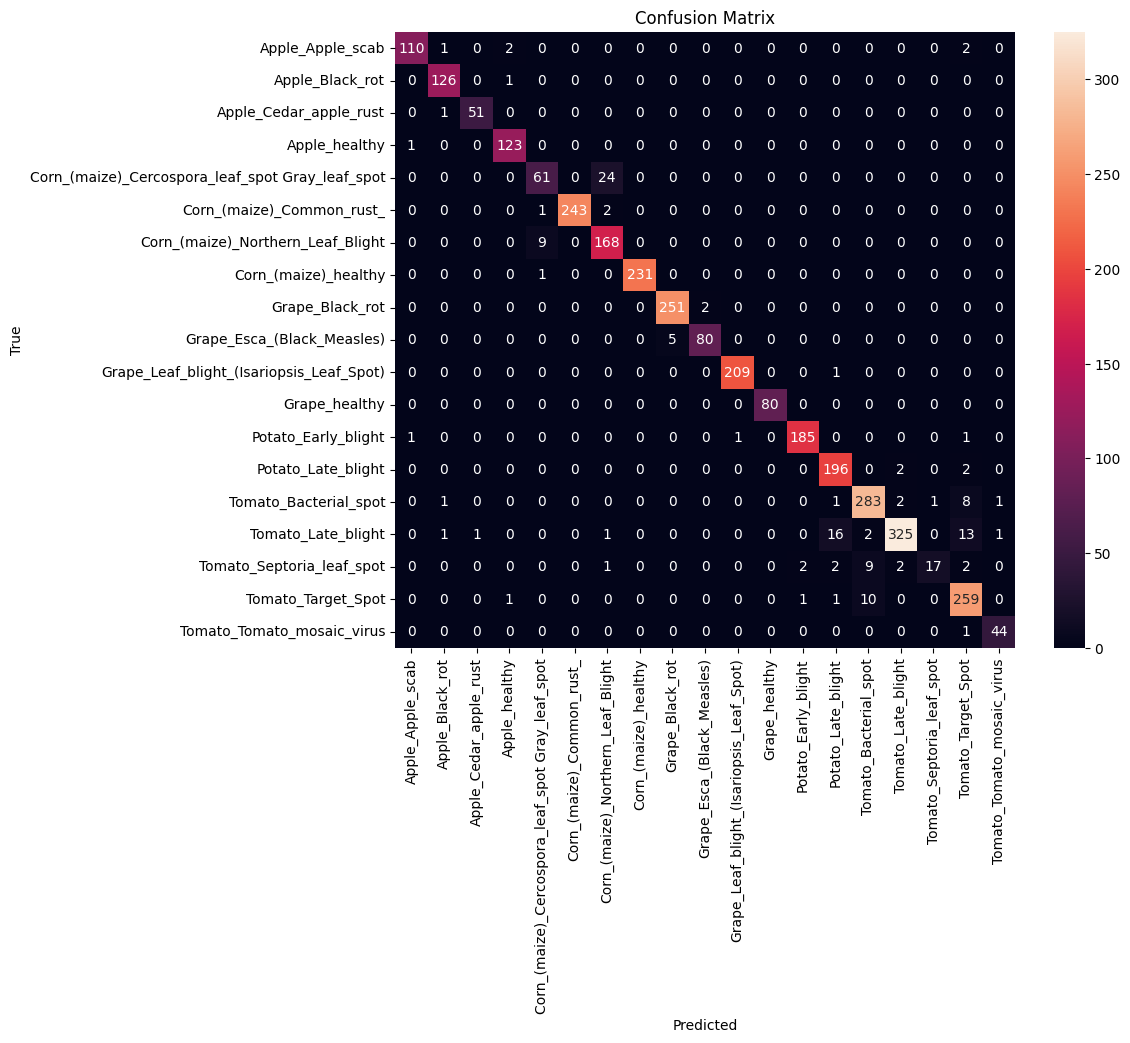

In [35]:
# Classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Load and preprocess image
img_path = r"D:\Genesys\Plant dieases detection\data\Potato_Early_blight\0d2325ff-4e3e-44bf-9614-e5ad6c23fc16___RS_Early.B 6797.JPG"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


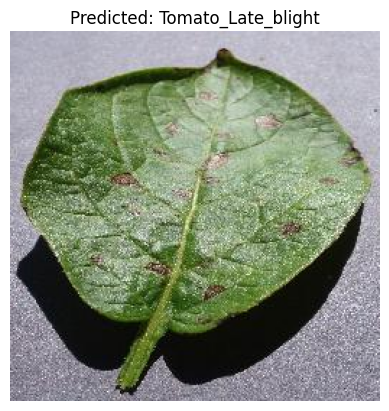

✅ Predicted class: Tomato_Late_blight


In [ ]:
# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
predicted_label = class_names[predicted_class]

# Show results
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()

print("Predicted class:", predicted_label)